# Progetto Big Data 
# UW-Madison GI Tract Image Segmentation 

Il seguente elaborato è stato prodotto dagli studenti **Salvatore Lucio Auria** e **Giuseppe Cacciafeda**.  

Il caso studio proposto dalla competizione Kaggle (<a href="https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation">clicca qui</a>) si incentra sulla tematica della **Semantic Segmentation**, task della **Computer Vision** che si occupa di classificare regioni di pixels relative ad un'immagine sfruttando tecniche di **Deep Learning**.

Molto spesso, per portare a termine un simile task, viene richiesta una classificazione di tipologia **Multi-Labeled**, nella quale ciascuna immagine potrebbe presentare al suo interno 
diverse regioni di pixels, ognuna appartenente ad una **label** differente. 

Nel caso studio presentato si propone l'obiettivo di classificare correttamente immagini diagnostiche relative a pazienti affetti da carcinoma del tratto gastro-intestinale monitorati per un periodo compreso tra 1-6 settimane. 

## Tipologia di Classificazione

Trattadosi di un caso studio nel quale viene richiesta una classificazione incentrata sulla presenza o sull'assenza di porzioni di pixels associate ad una specifica label (**segmentazione**), appare evidente come tale classificazione risulti di tipologia **binaria** Multi-Labeled.
Per definizione, questo problema di classificazione prevede la presenza di più labels all'interno dello stesso dato, le quali sono "non-esclusive" tra loro in termini di occorrenza nell'immagine; ciò implica che più labels possono essere individuate per un singolo esempio. 

Formalmente, il problema consiste nell'individuare una funzione $ M $ tale che venga rispettata la seguente relazione:


$$ f \colon \mathbb{R}^n \to \mathbb{R}^m \space M(x) = Y $$

dove $x \in R^n$ e $Y \in R^m$ con $m<n$ ed $m$ rappresenta il numero delle labels presenti nel dataset.

## Metriche di Valutazione

Questo caso di studio è stato valutato sfruttando diverse metriche di valutazione, tra cui:

1. **Coefficiente di Dice**, la quale metrica misura la similarità tra due insiemi di dati:

    $$DSC = \frac{2|A \cap B|}{|A| + |B|}$$

    dove l'insieme $A$ rappresenta il dataset di riferimento e l'insieme $B$ rappresenta l'insieme delle predizioni. 
    Tale coefficiente viene utilizzato per misurare la sovrapposizione tra la maschera di segmentazione predetta e quella reale.

    Segue una rappresentazione esplicativa:

    <center><img src="https://i.ibb.co/5kbT2Qd/dice2.jpg" width="480" height="240"></center>
    <br>
    <br>

    Tale coefficiente viene denominato anche "**F-score**", rappresentando la misura dell'accuratezza relativa ad un test. La misura tiene in considerazione **precision** e **recall** di quest'ultimo, dove la **precision** è il numero di veri positivi rapportato al numero di tutti i risultati positivi, mentre la **recall** è il numero di veri positivi rapportato al numero di tutti i test che sarebbero dovuti risultare positivi. L'F-score viene calcolato tramite la media armonica di precision e recall:

    $$F = \frac{2 \times Precision \times Recall}{Precision + Recall}$$ 

    dove precision e recall sono così definite:

    $$ Precision = \frac{TP}{TP+FP}$$
    $$ Recall = \frac{TP}{TP+FN}$$

2. **Intersection Over Union (IoU)**, che misura la sovrapposizione tra due segmentazioni. 
    L’IoU è calcolato come il rapporto tra l’area dell’intersezione e l’area dell’unione tra due insiemi:

    $$IoU(A,B)={{|A\cap B|} \over {|A\cup B|}}$$

In generale, l'IoU tende a penalizzare maggiormente le singole istanze di classificazione errate rispetto al Dice Coefficient, anche se entrambe le metriche concordano su questo. Ne consegue che il Dice Coefficient risulta essere più sensibile alle piccole differenze tra le predizioni e le labels.

Fonti: 
1. https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou
2. https://ieeexplore.ieee.org/document/363096 [PDF pagina 5]
3. https://ieeexplore.ieee.org/document/363096 [PDF pagina 5]
4. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6929325/

## Piattaforme utilizzate

Le piattaforme sfruttate per lo sviluppo dell'elaborato sono state le seguenti:

1. **Google Colab Pro**, (GPU: NVIDIA Tesla T4 VRAM 16GB)
2. **Kaggle**, (GPU: NVIDIA P100 VRAM 16GB)
3. **PC Locale**, (CPU: AMD Rayzen 7 2700X, GPU: NVIDIA RTX 2070 VRAM 8GB, RAM: 16GB)

La seconda è stata utilizzata per condurre la fase di **addestramento** del modello di rete e la fase di **inferenza** sui dati a disposizione.
La prima e l'ultima sono state invece utilizzate per la realizzazione delle fasi preliminari di costruzione del **Data Frame**, del **Data Generator** e per eseguire diversi esperimenti/tentativi.

Il seguente elaborato è frutto di diverse esecuzioni asincrone, avendo eseguito diversi modelli: di conseguenza il numero d'esecuzione delle verie celle di questo notebook non risulterà ordinato.

Colab Notebook (Tentativi):
1. https://colab.research.google.com/drive/1aXnShAzcKVqnum2M6HWQCDl-KYmY5dQ2#scrollTo=VGJXqhzeTB2E

## Installazioni preliminari

Per importare il modello di rete è necessario installare la libreria "**segmentation models**" (https://github.com/qubvel/segmentation_models) basata sul framework **TensorFlow** e sulla libreria **Keras**, i quali verranno successivamente descritti: 

In [2]:
! pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /private/var/folders/hm/lxgh9jyd51v9rbb2mp8kkchr0000gn/T/pip-req-build-kec1foy7
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /private/var/folders/hm/lxgh9jyd51v9rbb2mp8kkchr0000gn/T/pip-req-build-kec1foy7
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [3]:
! pip install segmentation-models

Segue uno script necessario affinché la libreria **segmentation model** funzioni correttamente all'interno della piattaforma **Kaggle**: 

In [ ]:
with open('/opt/conda/lib/python3.7/site-packages/efficientnet/keras.py', 'r') as f:
    contents = f.read()

new_contents = contents.replace('init_keras_custom_objects', 'init_tfkeras_custom_objects')

with open('/opt/conda/lib/python3.7/site-packages/efficientnet/keras.py', 'w') as f:
    f.write(new_contents)

## Python e Framework

All'interno del nostro progetto sono state utilizzate le seguenti librerie:
1. **Pandas**, libreria utilizzata per la manipolazione del dataset; 
2. **Numpy**, libreria matematica utilizzata per svolgere calcoli generalisti;
3. **OpenCV**, libreria utilizzata per l'elaborazione delle immagini;
4. **Matplotlib**, libreria utilizzata per il plotting dei grafici relativi ai dati del caso studio;
5. **Scikit-Learn**, libreria matematica utilizzata per importare tecniche di elaborazione dati;
6. **Albumentations**, libreria utilizzata durante la fase di **Data Augmentation** per effettuare modifiche sulle immagini;
7. **TensorFlow**, framework di **Machine Learning** per la creazione del modello;
8. **Keras**, libreria OpenSource di supporto a **TensorFlow**;
9. **Sys e Glob**, librerie utilizzate per facilitare l'accesso ai percorsi dei file;

Di seguito elenchiamo tutti gli import necessari per l'esecuzione delle varie operazioni all'interno del progetto:  

In [10]:
import numpy as np 
import pandas as pd
import os as os 
from glob import glob
import cv2 as cv2
import sys as sys
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
import albumentations as A
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint,ReduceLROnPlateau
from keras.applications import ResNet50
from keras.models import Model
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from keras.losses import binary_crossentropy
from keras import backend as K

## Data Preparation

Il dataset fornito da Kaggle è costituito dal file di record **'train.csv'** e dalla directory **'train'**: il primo raccoglie al suo interno tutte le **class** e le **segmentation** associate agli **id** delle immagini contenute nella seconda.

Per ispezione diretta, si noti come per ogni **id** e dunque per ogni **slice** siano associate tre **class**, le quali descrivono i tre organi costituenti il tratto gastro-intestinale:
1. **Large Bowel** (intestino crasso)
2. **Small Bowel** (intetsino tenue)
3. **Stomach** (stomaco)

In [11]:
train_label_file = pd.read_csv('/Users/giuseppecacciafeda/Documents/Unipa/Magistrale/BigData/DeepLearning/progetto_bigdata/dataset/train.csv', usecols=['id','class','segmentation'])

train_label_file.head(6)

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
5,case123_day20_slice_0002,stomach,NaN


Si può affermare come non tutti i record siano descritti da una segmentazione, come è altrettanto vero affermare che alcuni di essi siano descritti da segmentazioni differenti.
Di ciò, viene mostrato un esempio:

In [12]:
train_label_file.iloc[246:249]

,id,class,segmentation
246,case123_day20_slice_0083,large_bowel,17480 6 17745 8 18010 11 18275 13 18540 15 188...
247,case123_day20_slice_0083,small_bowel,22234 6 22499 9 22764 10 23030 11 23296 11 235...
248,case123_day20_slice_0083,stomach,11049 11 11313 16 11577 20 11842 23 12107 26 1...


Si noti come la stessa slice possegga tre segmentazioni differenti relative a ciascuna delle classi: di fatto, la presenza di una segmentazione in una specifica classe non esclude la presenza di altre in classi differenti.  

Di seguito viene mostrato il grafico relativo al numero di slice che posseggono o meno segmentazione, suddivise per classi:

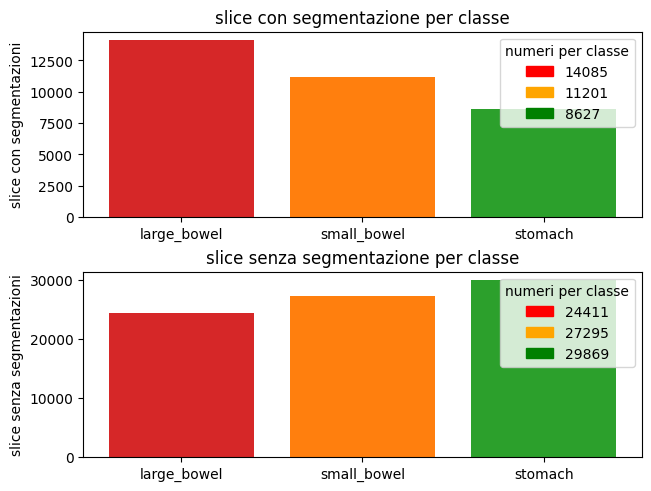

In [13]:
classes = ("large_bowel","small_bowel","stomach")
colors = ['tab:red','tab:orange','tab:green']
total_images = 38496
x = np.arange(len(classes))
width = 0.25
multiplier = 0

t_l_segment = train_label_file.loc[:, ["class","segmentation"]] 

query_no_segmentation = t_l_segment.query('segmentation.isnull()').groupby(["class"])["class"].count()

query_segmentation = t_l_segment.query('segmentation.notnull()').groupby(["class"])["class"].count()

query_seg_dict = query_segmentation.to_dict()

large_bowel_patch = mpatches.Patch(color='red', label=query_segmentation.get('large_bowel'))
small_bowel_patch = mpatches.Patch(color='orange', label=query_segmentation.get('small_bowel'))
stomach_patch = mpatches.Patch(color='green', label=query_segmentation.get('stomach'))

query_noseg_dict = query_no_segmentation.to_dict()

large_bowel_patch_2 = mpatches.Patch(color='red', label=query_no_segmentation.get('large_bowel'))
small_bowel_patch_2 = mpatches.Patch(color='orange', label=query_no_segmentation.get('small_bowel'))
stomach_patch_2 = mpatches.Patch(color='green', label=query_no_segmentation.get('stomach')) 

fig, ax = plt.subplots(2,layout='constrained')
 
ax[0].bar(query_seg_dict.keys(),query_seg_dict.values(),color=colors)

ax[0].set_ylabel('slice con segmentazioni')
ax[0].set_title('slice con segmentazione per classe')
ax[0].legend(title='numeri per classe', handles=[large_bowel_patch,small_bowel_patch,stomach_patch])

ax[1].bar(query_noseg_dict.keys(),query_noseg_dict.values(),color=colors)

ax[1].set_ylabel('slice senza segmentazioni')
ax[1].set_title('slice senza segmentazione per classe')
ax[1].legend(title='numeri per classe', handles=[large_bowel_patch_2,small_bowel_patch_2,stomach_patch_2])

plt.show()

In [14]:
percentage_lb = "{:.0%}".format((query_segmentation.get('large_bowel')/total_images)) 
percentage_sb = "{:.0%}".format((query_segmentation.get('small_bowel')/total_images))
percentage_st = "{:.0%}".format((query_segmentation.get('stomach')/total_images))
print("percentuale di immagini con segmentazione per classe : \n  intestino crasso:  %s  \n  intestino tenue:  %s \n  stomaco:  %s \n " % (percentage_lb,percentage_sb,percentage_st))

percentage_lb = "{:.0%}".format((query_no_segmentation.get('large_bowel')/total_images)) 
percentage_sb = "{:.0%}".format((query_no_segmentation.get('small_bowel')/total_images))
percentage_st = "{:.0%}".format((query_no_segmentation.get('stomach')/total_images))
print("percentuale di immagini senza alcuna segmentazione per classe : \n  intestino crasso:  %s  \n  intestino tenue:  %s \n  stomaco:  %s \n " % (percentage_lb,percentage_sb,percentage_st))

percentuale di immagini con segmentazione per classe : 
  intestino crasso:  37%  
  intestino tenue:  29% 
  stomaco:  22% 
 
percentuale di immagini senza alcuna segmentazione per classe : 
  intestino crasso:  63%  
  intestino tenue:  71% 
  stomaco:  78% 
 


Analizzando i risultati forniti dal grafico si evince come il numero di slice che non posseggono segmentazione sia maggiore rispetto a quello delle slice che invece la posseggono. 
Si può affermare dunque che il dataset risulta sbilanciato dal punto di vista della presenza delle segmentazioni.

Ritornando al codice, viene definito un metodo custom **preprocessing()**, al cui interno viene modificato il DataFrame originale.
Dall'attributo 'id' del file train.csv vengoo estratti:

1. **case** 
2. **day** 
3. **slice**

Inoltre, si estraggono la **path**, la **width** e la **height** associate ad ogni slice e le si inseriscono nel Data Frame precedentemente creato. Tali operazioni ci consentono una migliore gestione del dataset in fase di costruzione del modello dei dati.

In [15]:
def preprocessing(train_label_file =  pd.read_csv('/Users/giuseppecacciafeda/Documents/Unipa/Magistrale/BigData/DeepLearning/progetto_bigdata/dataset/train.csv', usecols=['id','class','segmentation']) ):

    ### Preprocessing del modello

    ## Analizzando la documentazione disposta nella kaggle competition
    ## e il train.csv, emergono due attributi fondamentali
    ## 1) il caso 
    ## 2) il giorno per ogni caso
    ## in maniera tale da rispettare la struttura del train set

    train_directory = "/Users/giuseppecacciafeda/Documents/Unipa/Magistrale/BigData/DeepLearning/progetto_bigdata/dataset/train"

    ## Estrazione del caso
    train_label_file["case"] = train_label_file["id"].apply(lambda x: int(x.split("_")[0].replace("case","")))
    ## Estrazione del giorno
    train_label_file["day"] = train_label_file["id"].apply(lambda x: int(x.split("_")[1].replace("day","")))
    ## Estrazione dello slice
    train_label_file["slice"] = train_label_file["id"].apply(lambda x: x.split("_")[3])

    ## La struttura di ogni sub-directory è organizzata in maniera tale da 
    ## suddividere le slices per
    ## 1) Caso (e.s: case2,case4,ecc..)
    ## 2) giorno per caso

    images = glob(os.path.join(train_directory, "**", "*.png"), recursive=True)

    ## Viene prelevato il percorso assoluto associato al train (questa operazione è necessaria
    ## in caso di submitting)
    temp_path_var = images[0].rsplit("/",4)[0]

    temp_path_list = []

    for i in range(0, train_label_file.shape[0]):
        temp_path_list.append(os.path.join(
            temp_path_var, "case"+str(train_label_file["case"].values[i]),
                        "case"+str(train_label_file["case"].values[i])+"_"+"day"+str(train_label_file["day"].values[i]),
                        "scans",
                        "slice_"+str(train_label_file["slice"].values[i])))

    train_label_file["path_temp"] = temp_path_list

    #------------------------------------------------ PASSO INTERMEDIO -----------------------------------------------#
    
    ## Viene creata una lista temporanea per contenere i percorsi di ogni slice all'interno della lista, 
    ## per poi utilizzarla all'interno del dataframe finale 
    ## il merge  viene utilizzato per associare ad ogni slice la path del percorso associato e per la successiva
    ## estrazione della dimensione dell'immagine
    
    temp_path_list = []

    for i in range(0, len(images)):
        temp_path_list.append(str(images[i].rsplit("_",4)[0]))
    
    tmp = pd.DataFrame()

    tmp['path_temp'] = temp_path_list
    tmp['path'] = images

    train_label_file = train_label_file.merge(tmp, on="path_temp").drop(columns=["path_temp"])

    train_label_file["width"] = train_label_file["path"].apply(lambda x : int(x.split("_")[-4].split("_")[0]))
    train_label_file["height"] = train_label_file["path"].apply(lambda x : int(x.split("_")[-3]))
    
    return train_label_file

In [62]:
preprocessing()

,id,class,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/Users/giuseppecacciafeda/Documents/Unipa/Magi...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/Users/giuseppecacciafeda/Documents/Unipa/Magi...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/Users/giuseppecacciafeda/Documents/Unipa/Magi...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/Users/giuseppecacciafeda/Documents/Unipa/Magi...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/Users/giuseppecacciafeda/Documents/Unipa/Magi...,266,266
...,...,...,...,...,...,...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN,30,0,0143,/Users/giuseppecacciafeda/Documents/Unipa/Magi...,266,266
115484,case30_day0_slice_0143,stomach,NaN,30,0,0143,/Users/giuseppecacciafeda/Documents/Unipa/Magi...,266,266
115485,case30_day0_slice_0144,large_bowel,NaN,30,0,0144,/Users/giuseppecacciafeda/Documents/Unipa/Magi...,266,266
115486,case30_day0_slice_0144,small_bowel,NaN,30,0,0144,/Users/giuseppecacciafeda/Documents/Unipa/Magi...,266,266


Viene definito un ulteriore metodo custom **restructure()**, il quale ricompone il Data Frame precedente in modo da utilizzare come attributi le classi 'large_bowel', 'small_bowel' e 'stomach'. La dimensione risulterà notevolmente ridotta rispetto quella originale (si passa da **115488** record a **38496** record, ovvero il numero esatto delle immagini a disposizione nel dataset):

In [16]:
#------------------------------------- RESTRUCTURING -----------------------------#

def restructure(train):
    
    ## Ricompongo il dataset in maniera tale da utilizzare
    ## come attributi le classi a disposizione (large_bowel,
    ## small_bowel_stomach). La dimensione sarà notevolmente ridotta rispetto
    ## quella originale
    
    new_train = pd.DataFrame({'id': train['id'][::3]})
    
    ## Prelevo la maschera large_bowel
    new_train['large_bowel'] = train['segmentation'][::3].values
    ## Prelevo la maschera small_bowel
    new_train['small_bowel'] = train['segmentation'][1::3].values
    ## Prelevo la maschera stomach
    new_train['stomach'] = train['segmentation'][2::3].values
    
    ## Prelevo path, case, day, slice, width, height
    new_train['path'] = train['path'][::3].values
    new_train['case'] = train['case'][::3].values
    new_train['day'] = train['day'][::3].values
    new_train['slice'] = train['slice'][::3].values
    new_train['width'] = train['width'][::3].values
    new_train['height'] = train['height'][::3].values
    
    new_train.reset_index(inplace=True, drop=True)
    new_train.fillna('',inplace=True)
    
    ## Aggiungo un attributo dove conteggio il numero di maschere associato 
    ## per ogni caso
    ## Scorro tutte le righe e verifico se le classi (large_bowel,small_bowel,stomach)
    ## abbiano il valore associato nella riga diverso dalla stringa vuota: in tal caso incrementerò
    ## l'indice
    new_train['count'] = np.sum(new_train.iloc[:,1:4] != '',axis=1)
    
    return new_train

In [17]:
data_frame = restructure(preprocessing())

data_frame = data_frame[(data_frame['case']!=7)|(data_frame['day']!=0)].reset_index(drop=True)
data_frame = data_frame[(data_frame['case']!=81)|(data_frame['day']!=30)].reset_index(drop=True)

data_frame.sample(5)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
24571,case43_day20_slice_0012,,,,/Users/giuseppecacciafeda/Documents/Unipa/Magi...,43,20,0012,266,266,0
10525,case140_day10_slice_0046,28673 4 28937 8 29202 10 29467 11 29733 11 299...,,21194 12 21448 6 21455 22 21711 36 21973 42 22...,/Users/giuseppecacciafeda/Documents/Unipa/Magi...,140,10,0046,266,266,2
13502,case19_day22_slice_0143,,,,/Users/giuseppecacciafeda/Documents/Unipa/Magi...,19,22,0143,360,310,0
1634,case129_day24_slice_0051,,,,/Users/giuseppecacciafeda/Documents/Unipa/Magi...,129,24,0051,360,310,0
22398,case89_day20_slice_0031,,,,/Users/giuseppecacciafeda/Documents/Unipa/Magi...,89,20,0031,266,266,0


## RLE-Encoding/Decoding

Si analizzi il seguente campione:

In [18]:
train_label_file.iloc[246:249]

,id,class,segmentation
246,case123_day20_slice_0083,large_bowel,17480 6 17745 8 18010 11 18275 13 18540 15 188...
247,case123_day20_slice_0083,small_bowel,22234 6 22499 9 22764 10 23030 11 23296 11 235...
248,case123_day20_slice_0083,stomach,11049 11 11313 16 11577 20 11842 23 12107 26 1...


Il campo 'segmentation' contiene la codifica **RLE (Run Lenght Encoding)** della **maschera** associata alla classe per ciascuna slice, dove per **maschera** si intende la regione dei pixels d'interesse contenuta all'interno dell'immagine originale presa in considerazione.

La codifica **RLE** è una forma di **loseless compression**, ovvero una compressione senza alcuna perdita di informazione, nella quale viene specificato il numero di occorrenze di pixels che presentano lo stesso valore di intensità, seguito proprio da tale valore. 

Nel caso studio preso in esame, lavorando con immagini in scala di grigio, i possibili valori assunti da un pixel sono compresi nell'intervallo [0,255]. Per elaborare la maschera sarà dunque necessario valutare la variazione d'intensità dei livelli di grigio dei pixels che compongono l'immagine.

Fonti: 
1. https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
2. https://www.kaggle.com/code/stainsby/fast-tested-rle/notebook


Sfruttando il campione estratto precedentemente dal dataset (slice 0083 equalizzata per motivi di visualizzazione), forniamo il seguente esempio:

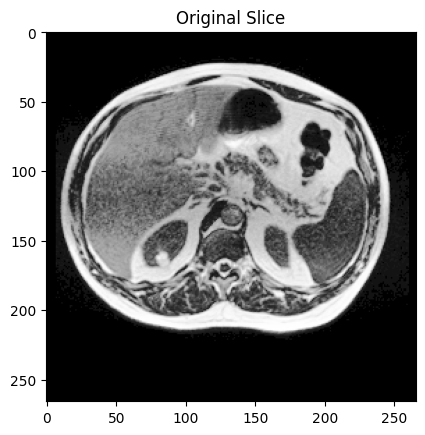

In [33]:
img = cv2.imread('slice_0083_266_266_1.50_1.50.png')
transform = A.Compose(A.Equalize(p=1))

transformed = transform(image=img)['image']

plt.imshow(transformed,cmap='bone')
plt.title("Original Slice")
plt.show()

Questa slice specifica (**case123_day20_slice_0083**) possiede tutte e 3 le maschere per classe. Estraiamo la maschera RLE della classe 'stomach':

In [21]:
rle_mask = train_label_file.iloc[246]['segmentation']
print(rle_mask)

17480 6 17745 8 18010 11 18275 13 18540 15 18805 18 19071 19 19337 20 19602 22 19868 22 20134 22 20399 23 20665 23 20931 23 21197 23 21464 22 21730 22 21996 22 22262 22 22529 21 22795 21 23060 22 23326 21 23591 22 23857 22 24123 21 24388 22 24655 20 24921 20 25188 18 25454 18 25720 18 25987 16 26253 15 26519 14 26785 13 27051 12 27317 11 27583 11 27848 12 28114 11 28380 11 28646 10 28912 9 29179 7 29446 5


Viene definito il metodo custom di decodifica **rle_decode()** che effettua la decodifica RLE sulla maschera fornita in input:

In [22]:
def rle_decode(mask_rle, shape, color=1):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

bdecoded_rle_mask = rle_decode(rle_mask,shape=(266,266,1))

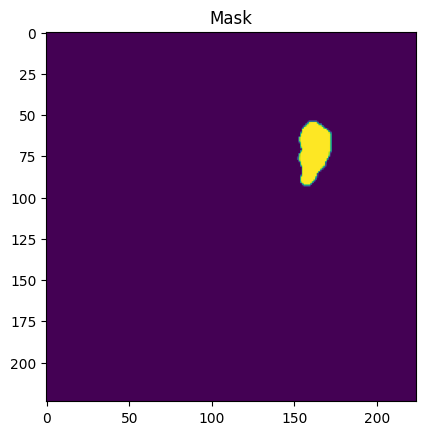

In [31]:
image_decoded = cv2.resize(bdecoded_rle_mask,(224,224))
plt.imshow(image_decoded)
plt.title("Mask")
plt.show()


Di seguito mostriamo a fianco la slice con la relativa maschera per la classe 'stomach':

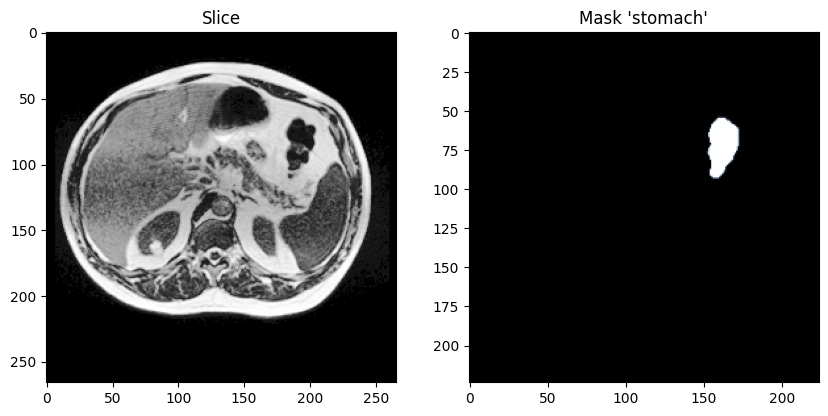

In [34]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(transformed, cmap='bone')
plt.title("Slice")
plt.subplot(2, 2, 2)
plt.imshow(image_decoded, cmap='bone')
plt.title("Mask 'stomach'")
plt.show()

## Data Modeling

Terminata la fase di **Data Preprocessing**, segue quella di **Data Modeling**, nella quale vengono estratte le immagini dal Data Frame e riorganizzate in **Batch**.
Una **Batch** è un sottoinsieme di dati avente dimensione fissata. Nel nostro caso, la dimensione scelta per ciascuna Batch è uguale a 16 e le immagini fornite in input saranno ridimensionate 160x160. 
Vengono inoltre estratte le varie segmentazioni codificate RLE dal Data Frame e decodificate, producendo così le varie maschere.

Viene definita una classe custom **CancerImages**, la quale funge da **Data Generator**, un oggetto preposto alla generazione dei dati, suddivisi in batch. Segue il codice:


In [25]:
##TLDR: LA batch size viene stabilita in relazione a
##1) VRAM della GPU
##2) la percentuale di VRAM per batch
##3) DImensione dell'immagine

## Batch_size = (15 * 1024 * 0.5) / (224 * 224 * 3) = 0,051 
## Per questione di tempistiche e praticità, si decide di imporre la dimensione pari a 16

## Data Augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.ToFloat(p=1),
    A.Normalize(mean=0,std=1,p=1)
])

BATCH_SIZE = 16

class CancerImages(tf.keras.utils.Sequence):
    # Inizializzazione della classe
    def __init__(self, img_width, img_height, df, subset="train", batch_size = BATCH_SIZE, shuffle=False):
        super().__init__()
        self.img_width = img_width
        self.img_height = img_height
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.df = df
        self.subset = subset
        self.on_epoch_end()

    def __len__(self):
        ## Fattore moltiplicativo di due data la data augmentation
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.batch_indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.batch_indexes)
    
    def __getitem__(self, index):
        ## Creazione dei dati organizzati in batch
        batch_indexes = self.batch_indexes[index * self.batch_size: (index+1) * self.batch_size]
        
        new_masks = np.empty((self.batch_size,self.img_height,self.img_width,3))
        new_img = np.empty((self.batch_size,self.img_height,self.img_width,3))
        
        for i,img_path in enumerate(self.df["path"].iloc[batch_indexes]):
            ## Estraggo le immagini dal dataframe
            orig_width = self.df['width'].iloc[batch_indexes[i]]
            orig_height = self.df['height'].iloc[batch_indexes[i]]
            
            img = self.__norm_eq_image(img_path)
            new_img[i, ] = img
            
            tmp_masks = np.empty((self.img_width,self.img_height,3))
            
            if self.subset == 'train':
                for j,k in zip([0,1,2],['large_bowel','small_bowel','stomach']):
                    ## Estraggo le maschere dal dataframe
                    rle_mask = self.df[k].iloc[batch_indexes[i]]
                    rle_decoded_mask = rle_decode(rle_mask, shape=(orig_height,orig_width,1))
                    
                    rle_decoded_mask = cv2.resize(rle_decoded_mask, (self.img_height,self.img_width))
                    
                    tmp_masks[:, :, j] = rle_decoded_mask
                    
                new_img[i, ], new_masks[i, :, :, :] = self.__augmentation(img,tmp_masks)
            
        if self.subset == "train": 
            return new_img, new_masks        
        else: return new_img
    
    def __norm_eq_image(self, img_path):
        img = cv2.imread(img_path, 0)
        h_img = self.__eq_image(img)
        new_size = (self.img_height,self.img_width)
        h_img = cv2.resize(h_img,new_size)
        h_img = h_img.astype(np.float32) / 255.
        h_img = np.expand_dims(h_img,axis=-1)
        return h_img
    
    ## Equalizzazione d'istogramma dell'immagine
    def __eq_image(self, img):
        transform = A.Compose([A.Equalize(p=1),A.ToFloat(p=1)])
        transformed = transform(image=img)['image']
        return transformed
    
    ## Data Augmentation
    def __augmentation(self,img,msk):
        
        augmented_masks = np.empty((self.img_height,self.img_width,3))
        
        msks = [msk[:,:,0], msk[:,:,1], msk[:,:,2]]
        
        transformed = transform(image=img, masks=msks)
        
        transformed_image = transformed['image']
        transformed_masks = transformed['masks']
        
        for i in [0,1,2]:
            augmented_masks[:,:,i] = transformed_masks[i]
        return transformed_image,augmented_masks

All'interno del codice vengono definiti una serie di metodi custom di supporto, ognuno preposto al compimento di una specifica operazione:

1. **__norm_eq_image()**: metodo utilizzato per eseguire sull'immagine un'operazione di normalizzazione e di equalizzazione;
2. **__eq__image()**: metodo utilizzato per eseguire sull'immagine un'operazione di equalizzazione d'istogramma per migliorarne il contrasto;
3. **__augmentation()**: metodo utilizzato per eseguire l'operazione di **Data Augmentation**;

## Data Augmentation

All'interno del codice precedente è possibile individuare il metodo **__augmentation()**, preposto ad eseguire l'operazione di **Data Augmentation** sull'insieme dei dati generati. 
Tale operazione viene sfruttata per introdurre all'interno di tale insieme di dati una varietà più elevata, rafforzando la capacità di generalizzazione del modello d'apprendimento automatico.
Tale operazione consiste nel modificare contemporanemanete le immagini e le relative maschere costituenti il Data Frame, adoperando delle trasformazioni coerenti che modifichino l'aspetto di entrambe in modo da non alterarne significativamente il contenuto informativo. 

Nel caso esaminato, le trasformazioni scelte sono state le seguenti:
1. **Flip Orizzontale**
2. **Rotazione**

La scelta è ricaduta sulle precedenti in virtù della loro proprietà **isotropica**, ovvero la caratteristica d'invarianza alla rotazione, necessaria affinché il contenuto dell'immagine trasformata rimanesse coerente con l'originale e non venisse alterato di molto. 

Seguono alcuni esempi di campioni del Data Frame sul quale è stata eseguita Data Augmentation, le relative segmentazioni e la loro sovrapposizione:

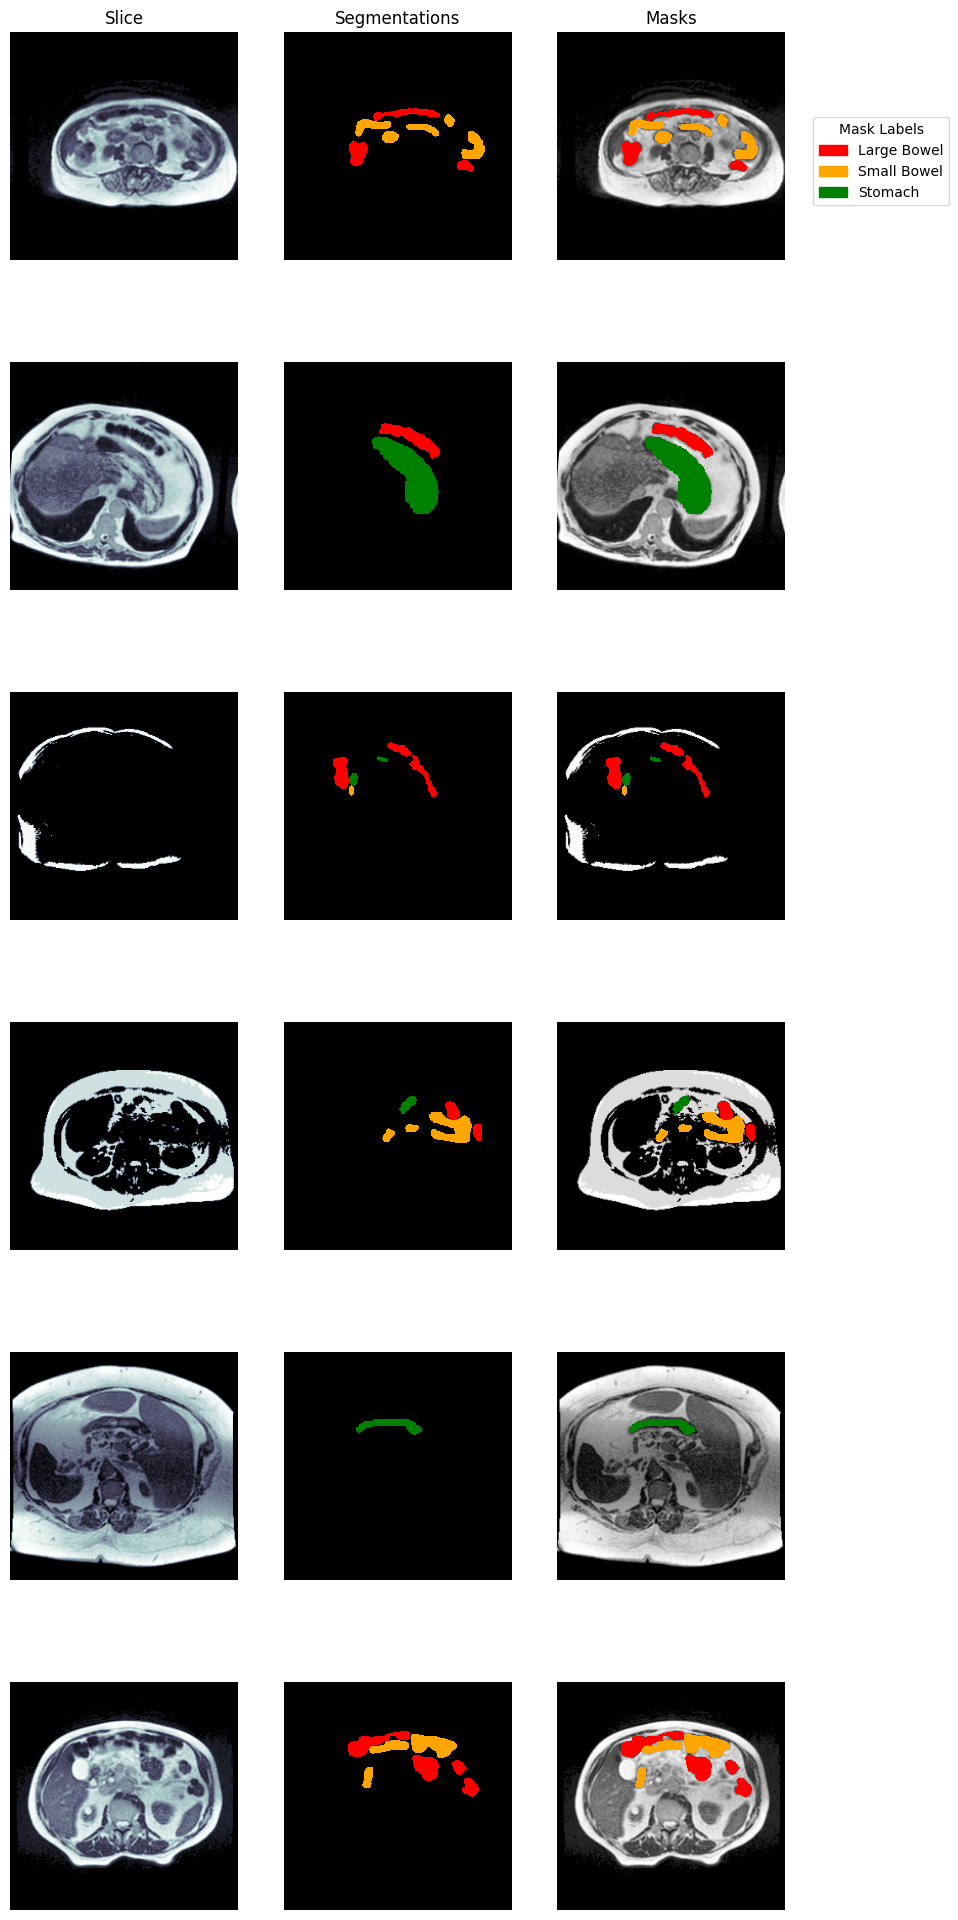

In [29]:
## Campioni
Masks = list(data_frame[data_frame['large_bowel']!=''].sample(BATCH_SIZE).index)
Masks += list(data_frame[data_frame['small_bowel']!=''].sample(BATCH_SIZE*2).index)
Masks += list(data_frame[data_frame['stomach']!=''].sample(BATCH_SIZE*3).index)

## Data Generator Batch
Batches = CancerImages(223,223,data_frame[data_frame.index.isin(Masks)],shuffle=True)

black_image = np.zeros((223, 223))

## Visualizzazione
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=3)
colors = ['red','orange','green']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = Batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    
    ax1 = fig.add_subplot(gs[i,1])
    
    s0 = ax1.imshow(black_image, cmap='bone')
    s1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    s2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask1),cmap=cmap2, alpha=1)
    s3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask1),cmap=cmap3, alpha=1)
    
    colors_1 = [im.cmap(im.norm(1)) for im in [s1,s2,s3]]

    ax2 = fig.add_subplot(gs[i, 2])
    if i==0:
        ax0.set_title("Slice")
        ax1.set_title("Segmentations")
        ax2.set_title("Masks")
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,title='Mask Labels')

    l0 = ax2.imshow(sample_img, cmap='gray')
    l1 = ax2.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]

    colors_2 = [im.cmap(im.norm(1)) for im in [l1,l2,l3]]

Si vedrà successivamente come tale tecnica, in relazione al dataset messo a disposizione, non fornirà i miglioramenti desiderati.  

## Tecniche di Validazione del modello

Affinchè una rete abbia una buona capacità di "discriminazione" dei dati, essa non deve essere affetta da **overfitting**; un tale modello è in grado di "adattarsi" molto bene ai dati presentati in ingresso (presentando bassi valori di errore), ma non avrebbe nessuna capacità di **generalizzare**, ovvero non sarebbe in grado di effettuare una corretta classificazione di dati al di fuori dell'insieme dei dati di addestramento: 

<center><img src="https://i.ibb.co/VjyjyNx/screenr4.jpg" width="480" height="240"></center>
<br>
<br>

Per evitare questa problematica, la tecnica tipicamente utilizzata per garantire la buona riuscita di un addestramento è la separazione tra insieme di **validazione** e insieme di **addestramento**, dove il primo è una sottoparte di quest'ultimo che non viene mai presentata alla rete: di fatto, la rete viene addestrata sul train set e, per verificarne l'efficacia, effettuerà un'operazione di **predizione** sul validation set e successivamente, conclusa la fase di addestramento, le verrà presentata una nuova porzione di dati totalmente **estranea** al dataset (**test set**).

<center><img src="https://i.ibb.co/7SZPc0G/screen5.jpg" width="480" height="240"></center>
<br>
<br>

Questo principio è generalmente corretto per insiemi di dati molto ampi, ma non sempre si hanno a disposizione insiemi del genere. Tra le possibili tecniche statistiche che permettono di ovviare a tale problema si menzionano la **validazione incrociata** ed il **Train Test Split**.

La **validazione incrociata** cosiddetta **K-fold** è una tecnica statistica che consiste nella suddivisione dell'insieme di dati in k raggruppamenti di uguale numerosità. Ad ogni iterazione la k-esima parte dell'insieme di dati diviene quella di validazione, mentre la restante porzione resta parte dell'insieme di addestramento. Il termine **K-fold**, fa riferimento al numero variabile d’insiemi (fold) identificati dal parametro k. 
Il modello viene poi allenato per ciascuna delle k parti, evitando quindi problemi di sovradattamento, ma anche di campionamento asimmetrico (e quindi affetto da distorsione) del campione osservato, tipico della suddivisione dei dati in due sole parti (ossia addestramento/validazione). 
In altre parole, il campione osservato viene suddiviso in gruppi di egual numerosità, escludendo successivamente in maniera iterativa un gruppo alla volta e con quelli non esclusi si cercherà di effettuare **predizione**, al fine di verificare la bontà del modello utilizzato.

Il **Train Test Split** è un metodo efficace, che dividendo il dataset in gruppi mutuamente esclusivi fornisce una visione più chiara delle reali prestazioni del modello. Ha però un difetto: dipende fortemente dalla composizione del dataset.

### Stratified Group K-Fold Cross Validation

Lo **Stratified Group K-Fold Cross Validation** è una tipologia di **Stratified K-Fold Cross Validation** che costruisce insiemi stratificati non sovrapposti identificati dal parametro k. Questo consente di mantenere suddivisioni bilanciate, dove il numero dei gruppi distinti è approssimativamente lo stesso per ciascun fold, nel quale la percentuale di elementi relativi a ciascuna classe viene preservata in relazione a quella rilevata all'interno del dataset originale.
Tale tecnica consente di raggruppare nello stesso fold immagini e segmentazioni relative allo stesso caso, in modo da evitare **Data Leakage**, ovvero la condizione per la quale dati non originariamente previsti divengono erroneamente l'input per l'addestramento del modello di rete che diviene così invalidato.

Segue un esempio illustrativo (non riferito al caso studio):

<center><img src="https://i.ibb.co/g7RYtS5/esempio-kfold.webp" width="480" height="240"></center>
<br>
<br>

Segue l'implementazione in Python:

In [73]:
n_splits=5
fold_selected=2 

def getKFold():
    skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for fold, (_, val_idx) in enumerate(skf.split(X=data_frame, y=data_frame['count'],groups =data_frame['case']), 1):
        data_frame.loc[val_idx, 'fold'] = fold
    
    data_frame['fold'] = data_frame['fold'].astype(np.uint8)
    
    train_ids = data_frame[data_frame["fold"]!=fold_selected].index
    valid_ids = data_frame[data_frame["fold"]==fold_selected].index

    return train_ids, valid_ids

def getTrain():
    [train_ids, valid_ids] = getKFold()
    train_generator = CancerImages(160,160,data_frame[data_frame.index.isin(train_ids)],shuffle=True)
    print(len(train_generator))
    return train_generator

def getTrainAndValGen():
    train_ids, valid_ids = getKFold()
    train_generator = CancerImages(160,160,data_frame[data_frame.index.isin(train_ids)],shuffle=True)
    val_generator = CancerImages(160,160,data_frame[data_frame.index.isin(valid_ids)])
    return train_generator, val_generator

train_gen, validation_gen = getTrainAndValGen()

### Train Test Split

Tramite il metodo **getSplit()** vengono prelevati casualmente dal dataset il 10% dei dati, i quali vengono raccolti all'interno del **validation set** così generato, e tramite il metodo **getTrain()** viene utilizzata la classe custom **CancerImages** per la generazione del train set. 

Il metodo **getTest()** preleva casualmente dal validation set il 30% dei dati per costituire un "test set fittizio": sarà successivamente più chiaro il motivo di tale scelta. Tramite il metodo train_test_spli() viene nuovamente suddiviso il validation set, divenendo il nuovo input per la classe CancerImages. 

In [76]:
def getSplit():
    train_set, val_set = train_test_split(data_frame,test_size = 0.1, shuffle = True, random_state = 42)    
    return train_set, val_set

def getTrain():
    [train_set, val_set] = getSplit()
    train_generator = CancerImages(160,160,train_set,shuffle=True)
    return train_set,train_generator,val_set

def getTest(val_set):
    new_val_set, test_set = train_test_split(val_set,test_size = 0.3, shuffle = True, random_state = 42)
    validation_gen = CancerImages(160,160,new_val_set,shuffle=True)
    return validation_gen, new_val_set, test_set
    
train_set, train_gen, val_set = getTrain()
validation_gen, new_val_set, test_set = getTest(val_set)

Fonti: 
1. https://machinelearningmastery.com/training-validation-test-split-and-cross-validation-done-right/
2. (metodo train_test_split) https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
3. (stratified GroupKFold) https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html
4. (stratified GroupKfold) https://machinelearningmastery.com/data-leakage-machine-learning/

## Scelta della funzione di Loss

Nella trattazione di questo paragrafo è necessario introdurre due concetti fondamentali: 
1. **Distribuzione di Bernoulli**
2. **Teoria dell'informazione**

### Distribuzione di Bernoulli

La distribuzione di Bernoulli di una singola variabile aleatoria X è definita come: 

$$P(X=1)=p$$
$$P(X=0)=(1-p)$$ 
ovvero
$$P(X=x)=p^x (1-p)^{1-x}$$ 

con $p \in [0,1]$

### Teoria dell'Informazione

L'entropia è la misura dell'incertezza associata ad una distribuzione nota $P(x)$ . Se l'informazione di un evento $x=x$ è nota come: 

$$I(x) = -\log P(x) $$ 

ed essendo l'entropia una misura, allora possiamo quantificarla in una distribuzione di probabilità utilizzando **l'entropia di Shannon** 

$$ H(x) = - \mathbb{E}_{x \sim P} [\log P(x)] $$ 

riscrivibile come:

$$ H(X) = -\sum_{x} P(x) \log_2 P(x) $$ 

ovvero il valore atteso riferito alla quantità di informazione da un evento estrapolato dalla distribuzione P(x). Se si vuole misurare la differenza tra due distribuzioni di probabilità $P(x)$ e $Q(x)$ in termini informativi, si può utilizzare la **Divergenza di Kullback-Leibler (KL)**: 

$$D_{KL}(P||Q) =  \mathbb{E}_{x \sim P} [\log P(x)-\log Q(x)]$$

Una quantità strettamente correlata alla divergenza KL è la **cross-entropy**:

$$H(P,Q)= H(P) +D_{KL}(P||Q)$$

ovvero

$$ H(P,Q) = - \mathbb{E}_{x \sim P} [\log Q(x)] $$ 

riscrivibile come: 

$$ H(P,Q) = -\sum_{x} P(x) \log Q(x) $$

La cross-entropy misura la dissimilarità (in termini informativi) tra due distribuzioni di probabilità (similmente a quanto fatto dalla divergenza KL). Nel caso studio preso in considerazione, ovvero un problema di **classificazione multi-etichettata**, non si esclude la presenza di una classe rispetto alle altre nello stesso dato. Vista la presenza di tre classi che garantiscono non-esclusività tra di loro, il problema può essere approssimato ad una **classificazione binaria multipla**:

1. presenza o assenza della maschera 'large_bowel'
2. presenza o assenza della maschera 'small_bowel'
3. presenza o assenza della maschera 'stomach'

Introduciamo dunque la funzione di loss **Binary Cross Entropy**: dati N campioni, le labels 'ground truth' (ovvero le labels prelevate dal dataset) $y_i$ e quelle $p_i$ predette

$$ L = -\frac{1}{N}\sum_{i=1}^{N}y_i\log(p_i)+(1-y_i)\log(1-p_i) $$

Minimizzare tale funzione equivale a minimizzare la differenza d'informazione tra due distribuzioni di probabilità.

### Scelta della funzione di loss finale

La funzione di loss finale scelta nel modello è una combinazione tra **Binary Cross Entropy** e **Dice Loss** (1- Dice Score): 

$$L_{final}= L_{BCE} + (0.5)*(1-DICE)$$

Il dice score ha la funzione di "penalizzatore", in quanto è necessario che se le maschere predette e le maschere "ground truth" possiedano uno score basso, la loss debba aumentare più di quanto aumenti nel caso in cui il dice score sia alto. 

Segue l'implementazione in Python:

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def iou(x_train,y_pred, smooth=1):
    intersection = K.sum(K.abs(x_train * y_pred), axis = [1,2,3])
    union = K.sum(x_train, axis = [1,2,3]) + K.sum(y_pred, axis = [1,2,3] ) - intersection 
    iou_coeff = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou_coeff

def iou_loss(x_train,y_pred):
    smooth = 1
    intersection = K.sum(K.abs(x_train * y_pred), axis = [1,2,3])
    union = K.sum(x_train, axis = [1,2,3]) + K.sum(y_pred, axis = [1,2,3] ) - intersection 
    iou_coeff = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return 1. - iou_coeff

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

def bce_iou_loss(x_train,y_pred):
    return binary_crossentropy(tf.cast(x_train, tf.float32), y_pred) + (0.5)*iou_loss(tf.cast(x_train, tf.float32), y_pred)

Fonti: 
1. Ian Goodfellow, Yoshua Bengio, Aaron Courville - Deep Learning (Capitolo 3, paragrafo 3.9.1 "Distribuzione di Bernoulli")
2. Ian Goodfellow, Yoshua Bengio, Aaron Courville - Deep Learning (Capitolo 3, paragrafo 3.13 "Information Theory")
3. (esempi pratici) https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451

## Modello della Rete

Seguendo la letteratura, la scelta del modello di rete è ricaduto su "**U-Net**": <a href="https://arxiv.org/abs/1505.04597"> è una rete neurale convoluzionale adatta alla segmentazioni di immagini diagnostiche in ambito biomedico</a> composta da due parti: 

1. **Contrazione** (a sinistra, chiamata anche fase di '**encoding**')
2. **Espansione** (a destra, chiamata anche fase di '**decoding**')

Vengono applicate due **convoluzioni** consecutive con kernel di dimensione 3x3, ognuna seguita da una **ReLU** (rectified linear unit, tipica funzione di attivazione della forma $f(x) = \max(0,x)$) e un'operazione di **max pooling** con kernel di dimensione 2x2 e stride pari a 2. Queste operazioni svolte consecutivamente costituiscono un blocco di **downsampling** e lo si usa della fase di contrazione. Ad ogni step di downsampling, viene raddoppiato il numero di **feature per canale**:

<center><img src="https://i.ibb.co/2SXfPpZ/unet.jpg" width="720" height="480"></center>
<br>
<br>

> Esempio: nel primo blocco di downsampling si può costruire una feature map di dimensione 64, al successivo si ha una feature map di 128 e così via

Nella fase di espansione invece, si effettua una **convoluzione** con kernel di dimensione 2x2 che dimezza il numero di feature per canale, una **concatenazione** con la parte **'tagliata'** della feature map (operazione necessaria poiché in ogni convoluzione, i bordi dei pixel vengono 'persi') corrispondente nel percorso di contrazione e due **convoluzioni** con kernel di dimensione 3x3, ognuna di esse seguite da una ReLU. Queste operazioni, invece, costituiscono un blocco di **upsampling**. Il layer finale si occupa di effettuare il mapping del vettore (di dimensione nxn) delle feature al numero di classi desiderato.  

Nel caso studio specifico, l'architettura U-Net scelta differisce per dimensione delle feature map scelte: la letteratura suggerisce 4 blocchi di dimensioni consecutive [64,128,256,512,1024] mentre l'implementazione corrente presenta la seguente configurazione [16,32,64,128,256]. 

### Funzione di attivazione (Ultimo Layer)

La scelta della funzione di attivazione dell'ultimo layer del modello di rete è ricaduta sulla funzione "**Sigmoide Logistica**", anche in virtù della scelta della **Binary Cross Entropy** come funzione di loss.

La funzione **Sigmoide** presenta delle caratteristiche tali da riuscire a produrre un parametro $p$ in output dal valore compreso $p \in [0,1]$ , esattamente come una distribuzione di Bernoulli. 
Da qui, il suo dominio coincide con l'insieme $\mathbb{R}$ ed il suo codominio con $C \in [0,1]$ (da non confondere con l'insieme dei complessi $\mathbb{C}$).

La sua formulazione è la seguente:

$$\sigma(x)=\frac{e^x}{1+e^x}$$

Questa funzione è continua e derivabile in $\mathbb{R}$ e raggiunge la **saturazione** quando il suo argomento risulta molto positivo o molto negativo, presentando di conseguenza un andamento piatto (insensibile) ai piccoli cambiamenti relativi al suo input. 

<center><img src="https://i.ibb.co/6gDP9Jy/sigmoide.jpg" width="720" height="480"></center>
<br>
<br>

### Discesa lungo il Gradiente

Il processo di apprendimento dei pesi viene effettuato tramite la tecnica di **Discesa lungo il Gradiente** dove la funzione di loss viene derivata rispetto al vettore dei pesi $w$: 

$$ \frac{\partial L}{\partial w} = \frac{\partial L}{\partial y'} \frac{\partial y'}{\partial w}$$

Ipotizzando che la funzione di loss sia l'errore quadratico medio $ L = \frac{1}{n}\sum_{i=1}^n(y'_i-y)^2$ dove $y' $ è il valore predetto e $y$ è il valore reale, allora la sua derivata sarà:

$$ \frac{\partial L}{\partial y'}=y'-y$$ 

(il termine '-2' viene omesso).

> (per questioni di praticità di notazione utilizzeremo questa loss ma è chiaro che il processo avviene coinvolgendo la Binary Cross Entropy)  

Assumendo di aver calcolato il valore predetto (ultimo layer), si applica la funzione sigmoide $y'=\sigma(w^tx)$ ; la derivata della sigmoide sarà della forma:

$$\frac{\partial \sigma(z)}{\partial z} = \sigma(z)(1-\sigma(z))$$ 

In conclusione avremo, con $z=w^tx $ (ovvero l'input della rete):

$$ \frac{ \partial y'}{\partial w} = \frac{1}{1+exp(w^tx+b)}(1- \frac{1}{1+exp(w^tx+b)} ) $$

La regola di aggiornamento dei pesi, detta anche **Delta Rule** viene definita come: 

$$w^{new}=w^{old}-\eta \frac{\partial L}{\partial w}$$

dove $\eta$ rappresenta il **Learning Rate** della rete.

Fonti:
1. https://arxiv.org/abs/1505.04597
2. https://datascience.stackexchange.com/questions/30676/role-derivative-of-sigmoid-function-in-neural-networks 
3. Intelligenza Artificiale, NIllson (Capitolo 3, paragrafo 3.3 "Reti Neurali")

### Transfer Learning

Il **Transfer Learning** è una tecnica di Machine Learning che sfrutta un modello sviluppato per adempiere ad un determinato compito e lo **riutilizza** come base di partenza per la costruzione di un altro modello che svolge un compito differente dal precedente.  

Un modello pre-addestrato è una rete salvata che è stata precedentemente allenata su un dataset di grandi dimensioni. Tale rete può essere utilizzata in combinazione con un ulteriore modello, in modo da personalizzarlo per svolgere una determinata attività.

L'intuizione alla base del **Transfer Learning** per la classificazione delle immagini è la seguente: se un modello viene addestrato su un set di dati sufficientemente ampio e generale, sarà in grado già di per sé di discrimnare in maniera ottimale gli inputs forniti in ingresso e dunque sfruttare queste **features maps** prodotte senza dover iniziare da zero l'addestramento di un modello di grandi dimensioni su un set di dati molto ampio permetterà di avere migliori prestazioni in minor tempo.

#### ResNet34 Backbone

La scelta della **Backbone** (spina-dorsale, ovvero il primo stage del modello (encoding)) per quanto concerne il modello di rete utilizzato è ricaduta su "**ResNet34**", pre-caricata coi **pesi** di **Imagenet**, dataset di dimensione molto elevata. 

Segue un esempio illustrativo dell'architettura completa di "ResNet34":

<center><img src="https://i.ibb.co/Nxk6nwN/resnet34.png" width="480" height="720"></center>
<br>
<br>

L'utilizzo di ResNet34 è stato preso in considerazione per due motivi:
1. L'addestramento di tale modello è avvenuto sul dataset Imagenet, di dimensioni notevolmente elevate (migliori performance);
1. Per cercare di risolvere il problema della degradazione dell'accuracy dell'addestramento (conseguente aumento del valore della funzione di loss);

La degradazione dell'accuracy dell'addestramento è una conseguenza dell'aumento della complessità delle rete, in particolar modo in proporzione alla sua "profondità". 

Per ovviare a tale problematica, viene introdotto il concetto di **Residual Learning**: l'input di un layer della rete viene ripresentato in combinazione con l'output del layer immediamente successivo. Ciò consente di ritardare l'incremento del fenomeno di degradazione ed attutire il **Vanishing Gradient**, la condizione nella quale l'aggiornamento del Gradiente diminuisce esponenzialmente.

Fonti:
1. https://arxiv.org/abs/1512.03385
2. https://www.tensorflow.org/tutorials/images/transfer_learning?hl=it
3. https://machinelearningmastery.com/transfer-learning-for-deep-learning/

### Scelta Architetturale Definitiva

In conclusione, il modello di rete scelto è il seguente: 

*U-Net con Backbone ResNet34*

Input-shape 160x160x3

*Features Map*: [64,128,256,512]
1. *Encoding*: [64,128,256,512] (da ResNet34)
2. *Decoding*: [256,128,64,32,16] (da U-Net)

*Funzione di attivazione dell'ultimo layer*: *Sigmoide*

*Funzione di loss*: *Binary-Cross Entropy* pesata per il 50% con *Regolarizzatore Dice Coefficient*

Fonti:
1. https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/models/unet.py
2. https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/backbones/backbones_factory.py

## Comparazione tra Modelli

Una volta scelta l'architettura di rete, si è pensato di effettuare una serie di "esperimenti/tentativi" per verificare quanto l'introduzione di una tecnica di manipolazione dati, ovvero la **Data Augmentation**, potesse incidere sulle prestazioni del modello in fase di addestramento.

E' stata valutata inoltre l'influenza della tipologia di **Cross Validation** adottata per la generazione del train set e del validation set.

La metodologia utilizzata per la scelta del miglior modello si basa sulla raccolta dei migliori valori per epoca di ciascuna combinazione **"Modello" + "Data Augmentation" + "Cross-Validation"**.

Ad ogni configurazione è stata applicata la **riduzione del Learning Rate** al raggiungimento del **plateau** (ReduceLROnPlateau), tecnica che riduce il learning rate qualora il valore relativo alla funzione di loss in validazione non dovesse diminuire per un numero prestabilito di epoche.

Nel caso studio considerato, la tolleranza scelta (**patience**) relativa al numero di epoche è stata fissata a 3, con riduzione del LR di $10^-1$ . 

Il numero di epoche è stato fissato a 15 per ciascuna configurazione.

### 1. U-Net-ResNet Model (No Data Augmentation - Stratified Group K-Fold)

In [39]:
EPOCHS = 15

sm.set_framework('tf.keras')
u_net_resnet_model = Unet('resnet34',input_shape=(160, 160, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')

checkpoint = ModelCheckpoint(
    'unet_model_kaggle_kfold.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

lr_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    min_delta=0.0001,
)

u_net_resnet_model.compile(optimizer='adam',
                    loss=bce_dice_loss,
                    metrics=[dice_coef, iou])

u_net_resnet_model.summary()

history = u_net_resnet_model.fit(
    train_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint,lr_plateau],
    validation_data = validation_gen,
    workers=4,
    use_multiprocessing=True
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 160, 160, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, 166, 166, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

### 1. Misurazioni rilevate

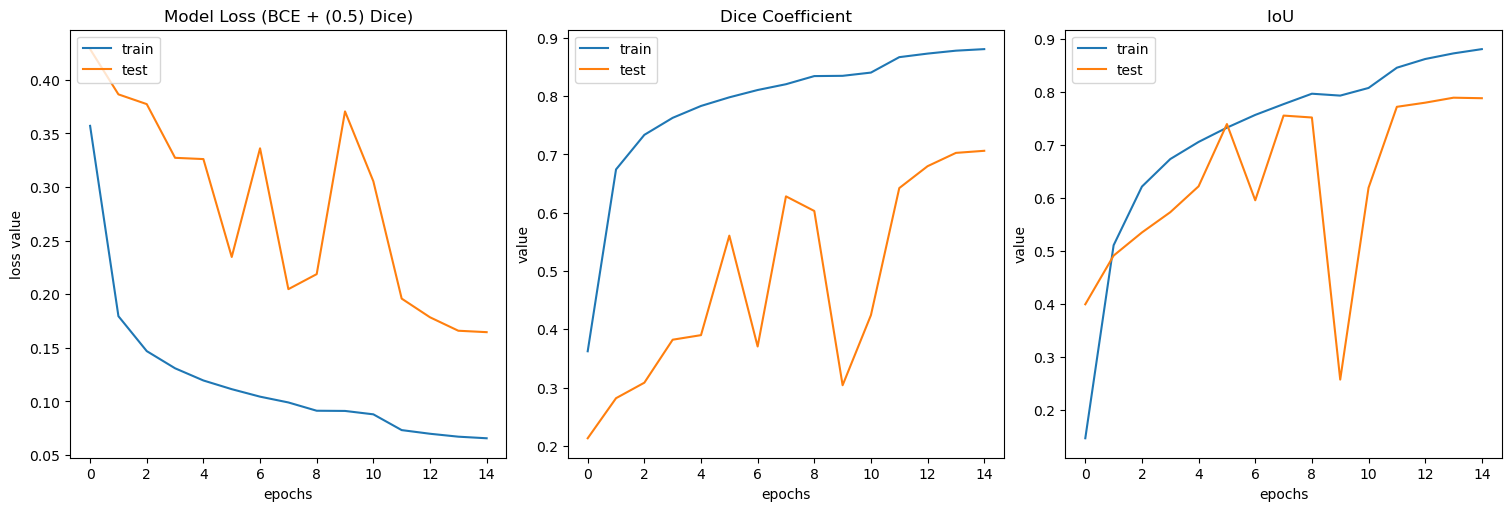

In [40]:
fig, ax = plt.subplots(1,3,figsize=(15, 5), layout='constrained')

ax[0].set_title('Model Loss (BCE + (0.5) Dice)')
ax[0].set_ylabel('loss value')
ax[0].set_xlabel('epochs')
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].legend(['train', 'test'], loc='upper left')

ax[1].set_title('Dice Coefficient')
ax[1].set_ylabel('value')
ax[1].set_xlabel('epochs')
ax[1].plot(history.history['dice_coef'])
ax[1].plot(history.history['val_dice_coef'])
ax[1].legend(['train', 'test'], loc='upper left')

ax[2].set_title('IoU ')
ax[2].set_ylabel('value')
ax[2].set_xlabel('epochs')
ax[2].plot(history.history['iou'])
ax[2].plot(history.history['val_iou'])
ax[2].legend(['train', 'test'], loc='upper left')

plt.show()

Valori migliori:

loss: 0.0657 - dice_coef: 0.8805 - iou: 0.8814 - val_loss: 0.1646 - val_dice_coef: 0.7061 - val_iou: 0.7887

### 2. U-Net-ResNet Model (Data Augmentation - Train Test Split)

In [19]:
EPOCHS= 15

sm.set_framework('tf.keras')
u_net_resnet_model = Unet('resnet34',input_shape=(160, 160, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')

checkpoint = ModelCheckpoint(
    'unet_resnet_model_aug_split.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

lr_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    min_delta=0.0001,
)

u_net_resnet_model.compile(optimizer='adam',
                    loss=bce_dice_loss,
                    metrics=[dice_coef, iou])

u_net_resnet_model.summary()

history = u_net_resnet_model.fit(
    train_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint,lr_plateau],
    validation_data = validation_gen,
    workers=4,
    use_multiprocessing=True
)

85521592/85521592 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 160, 160, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)            

### 2. Misurazioni rilevate


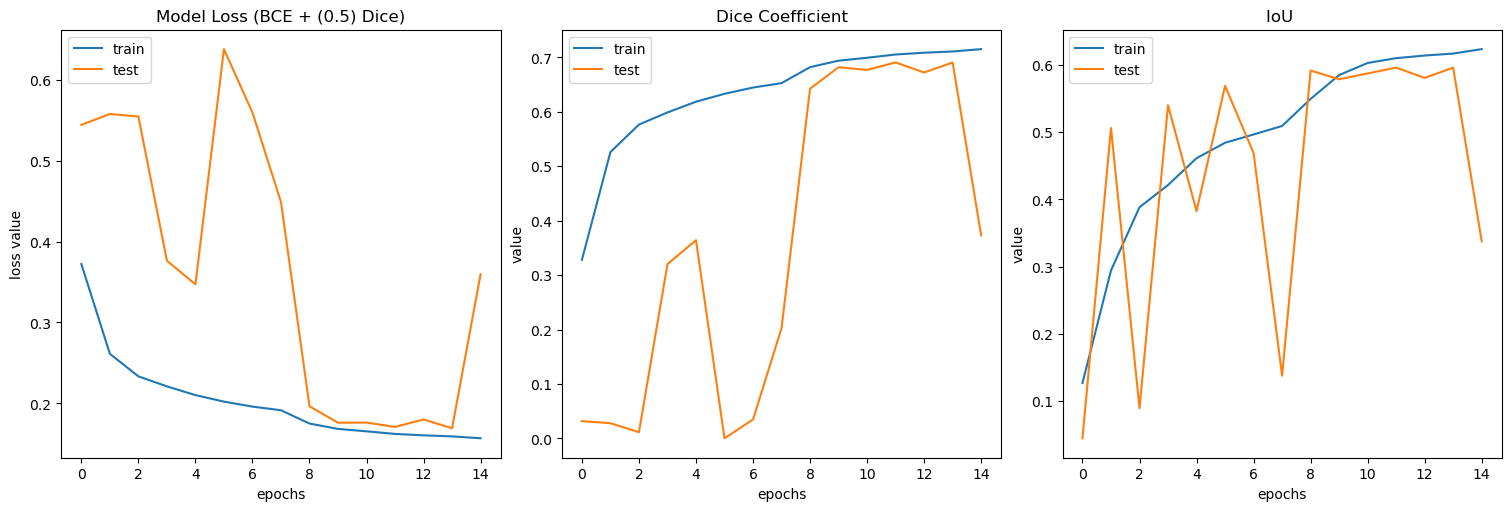

In [20]:
fig, ax = plt.subplots(1,3,figsize=(15, 5), layout='constrained')

ax[0].set_title('Model Loss (BCE + (0.5) Dice)')
ax[0].set_ylabel('loss value')
ax[0].set_xlabel('epochs')
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].legend(['train', 'test'], loc='upper left')

ax[1].set_title('Dice Coefficient')
ax[1].set_ylabel('value')
ax[1].set_xlabel('epochs')
ax[1].plot(history.history['dice_coef'])
ax[1].plot(history.history['val_dice_coef'])
ax[1].legend(['train', 'test'], loc='upper left')

ax[2].set_title('IoU ')
ax[2].set_ylabel('value')
ax[2].set_xlabel('epochs')
ax[2].plot(history.history['iou'])
ax[2].plot(history.history['val_iou'])
ax[2].legend(['train', 'test'], loc='upper left')

plt.show()

Valori migliori:

loss: 0.1592 - dice_coef: 0.7109 - iou: 0.6170 - val_loss: 0.1692 - val_dice_coef: 0.6906 - val_iou: 0.5961

### 3. U-Net-ResNet Model (Data Augmentation - Stratified Group K-Fold)

In [38]:
EPOCHS= 15

sm.set_framework('tf.keras')
u_net_resnet_model = Unet('resnet34',input_shape=(160, 160, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')

checkpoint = ModelCheckpoint(
    'unet_resnet_model_aug_kfold.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

lr_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    min_delta=0.0001,
)

u_net_resnet_model.compile(optimizer='adam',
                    loss=bce_dice_loss,
                    metrics=[dice_coef, iou])

u_net_resnet_model.summary()

history = u_net_resnet_model.fit(
    getTrain(),
    epochs=EPOCHS,
    callbacks=[checkpoint,lr_plateau],
    validation_data = validation_gen,
    workers=4,
    use_multiprocessing=True
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 160, 160, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, 166, 166, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

### 3. Misurazioni rilevate


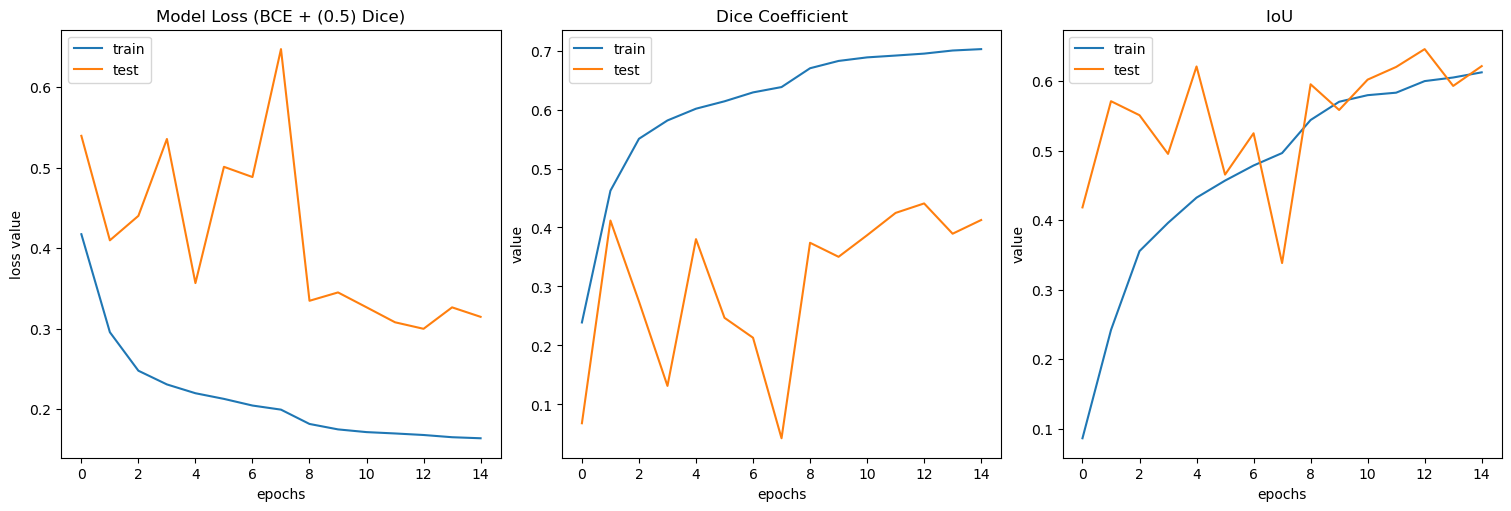

In [39]:
fig, ax = plt.subplots(1,3,figsize=(15, 5), layout='constrained')

ax[0].set_title('Model Loss (BCE + (0.5) Dice)')
ax[0].set_ylabel('loss value')
ax[0].set_xlabel('epochs')
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].legend(['train', 'test'], loc='upper left')

ax[1].set_title('Dice Coefficient')
ax[1].set_ylabel('value')
ax[1].set_xlabel('epochs')
ax[1].plot(history.history['dice_coef'])
ax[1].plot(history.history['val_dice_coef'])
ax[1].legend(['train', 'test'], loc='upper left')

ax[2].set_title('IoU ')
ax[2].set_ylabel('value')
ax[2].set_xlabel('epochs')
ax[2].plot(history.history['iou'])
ax[2].plot(history.history['val_iou'])
ax[2].legend(['train', 'test'], loc='upper left')

plt.show()

Valori migliori:

loss: 0.1678 - dice_coef: 0.6949 - iou: 0.6001 - val_loss: 0.2997 - val_dice_coef: 0.4408 - val_iou: 0.6460

### 4. U-Net-ResNet Model (No Data Augmentation - Train Test Split)

In [25]:
EPOCHS= 15

sm.set_framework('tf.keras')
u_net_resnet_model = Unet('resnet34',input_shape=(160, 160, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')

checkpoint = ModelCheckpoint(
    'unet_model_kaggle.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

lr_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    min_delta=0.0001,
)

u_net_resnet_model.compile(optimizer='adam',
                    loss=bce_dice_loss,
                    metrics=[dice_coef, iou])

u_net_resnet_model.summary()

history = u_net_resnet_model.fit(
    train_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint,lr_plateau],
    validation_data = validation_gen,
    workers=4,
    use_multiprocessing=True
)

85521592/85521592 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 160, 160, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)            

### 4. Misurazioni rilevate


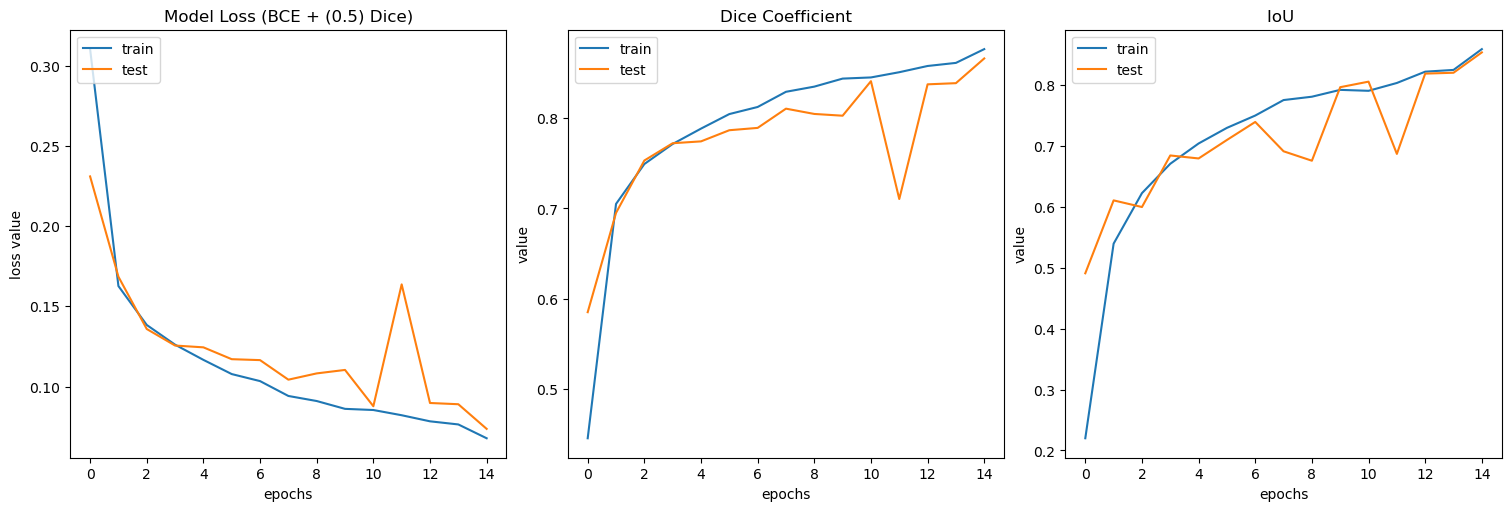

In [26]:
fig, ax = plt.subplots(1,3,figsize=(15, 5), layout='constrained')

ax[0].set_title('Model Loss (BCE + (0.5) Dice)')
ax[0].set_ylabel('loss value')
ax[0].set_xlabel('epochs')
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].legend(['train', 'test'], loc='upper left')

ax[1].set_title('Dice Coefficient')
ax[1].set_ylabel('value')
ax[1].set_xlabel('epochs')
ax[1].plot(history.history['dice_coef'])
ax[1].plot(history.history['val_dice_coef'])
ax[1].legend(['train', 'test'], loc='upper left')

ax[2].set_title('IoU ')
ax[2].set_ylabel('value')
ax[2].set_xlabel('epochs')
ax[2].plot(history.history['iou'])
ax[2].plot(history.history['val_iou'])
ax[2].legend(['train', 'test'], loc='upper left')

plt.show()

Valori Migliori:

loss: 0.0678 - dice_coef: 0.8767 - iou: 0.8589 - val_loss: 0.0737 - val_dice_coef: 0.8664 - val_iou: 0.8535

## Scelta del modello migliore

Vengono riassunti tutti i valori prodotti dai precedenti modelli in fase di **addestramento** e di **validazione** per quanto concerne la **loss**, il **dice coefficient** e l'**IoU coefficient**:

<table>
  <tr>
    <th>Modello</th>
    <th>Loss</th>
    <th>Dice </th>
    <th>IoU</th>
    <th>Validation Loss</th>
    <th>Validation Dice </th>
    <th>Validation IoU</th>
  </tr>
  <tr>
    <td>1</td>
    <td>0.0657</td>
    <td>0.8805</td>
    <td>0.8814</td>
    <td>0.1646</td>
    <td>0.7061</td>
    <td>0.7887</td>
  </tr>
  <tr>
    <td>2</td>
    <td>0.1592</td>
    <td>0.7109</td>
    <td>0.6170 </td>
    <td>0.1692</td>
    <td>0.6906</td>
    <td>0.5961</td>
  </tr>
  <tr>
    <td>3</td>
    <td>0.1678</td>
    <td>0.6949</td>
    <td>0.6001</td>
    <td>0.2997</td>
    <td>0.4408</td>
    <td>0.6460</td>
  </tr>
  <tr>
    <td>4</td>
    <td>0.0678</td>
    <td>0.8767</td>
    <td>0.8589</td>
    <td>0.0737</td>
    <td>0.8664 </td>
    <td>0.8535</td>
  </tr>
</table>

In base a quanto riportato nella tabella precedente, il modello scelto è stato il **n.4**:

*U-Net-ResNet Model (No Data Augmentation - Train test Split)*

## Predizione

Kaggle originariamente permetteva la **submission** di un notebook con relativo modello e produceva uno score sulle predizioni effettuate eseguendolo su un ambiente virtuale, senza però fornire direttamente alcun test set.

Al momento della submission di questo elaborato, tale meccanismo ha smesso di funzionare. Di conseguenza, è stato necessario costruire un "test set fittizio", prelevato dallo stesso train set: tramite il metodo **train_test_split()** applicato nuovamente al validation set è stato possibile prelevare il 30% di quest'ultimo, percentuale di dati che non è stata **mai** presentata alla rete in fase di addestramento.  

### Predizione sul Validation Set

E' possibile adesso testare il modello sul **Validation Set**, mostrando graficamente la differenza tra le **predizioni** effettuate e i dati reali:

In [27]:
custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou': iou,
    'bce_dice_loss': bce_dice_loss  
}

model = load_model('/kaggle/working/unet_model_kaggle.h5', custom_objects=custom_objects)

6/6 [==============================] - 1s 12ms/step


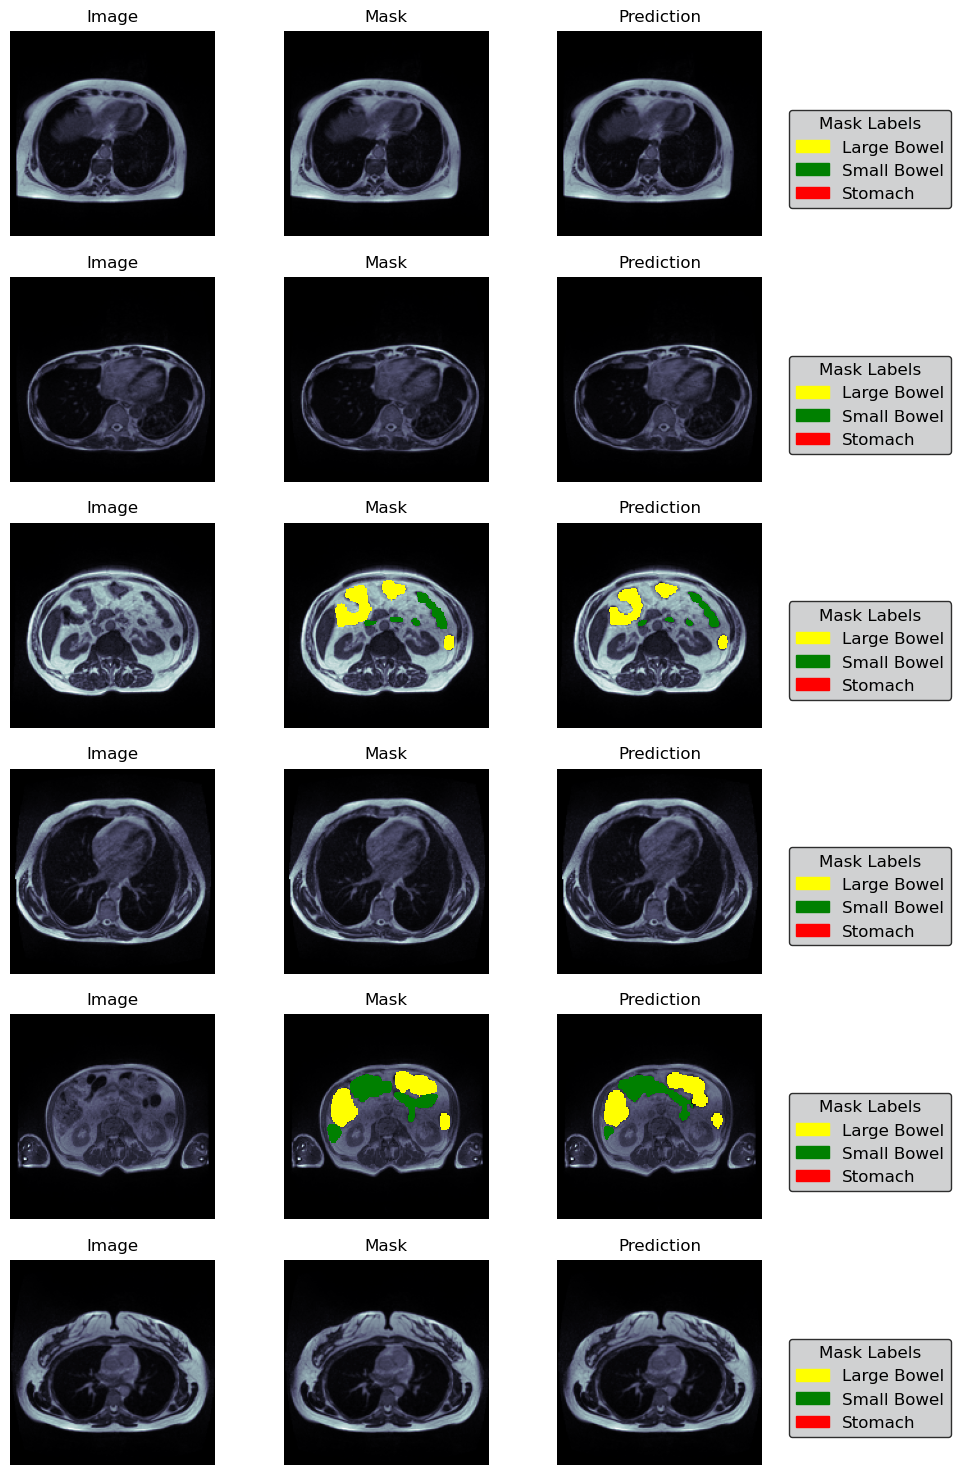

In [28]:
val_batches = CancerImages(160,160,val_set.iloc[400:406,:],subset="train", batch_size = 1, shuffle=False)
preds = model.predict(val_batches,verbose=1) 

Threshold = 0.5

## Caricamento
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=8, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

## Compariamo validazione e predizione
for i in range(6):
    
    ## Carichiamo immagini e maschere dal validation set
    images, mask = val_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ## Carichiamo le maschere relative la predizione
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    ## Se una certa soglia viene superata (0.5), vi è maschera di predizione 
    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Prediction", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)
   
    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')

Come è possibile notare, su 6 predizioni di immagini campione:
1. 5 predizioni risultano corrette;
2. La predizione n.5 è parzialmente corretta: una porzione sulla destra di 'small bowel' è stata erroneamente classificata come 'large bowel';

## Predizione sul Test Set (Inferenza simulata)

Infine, il modello effettua predizioni sul **test set**:

6/6 [==============================] - 0s 13ms/step


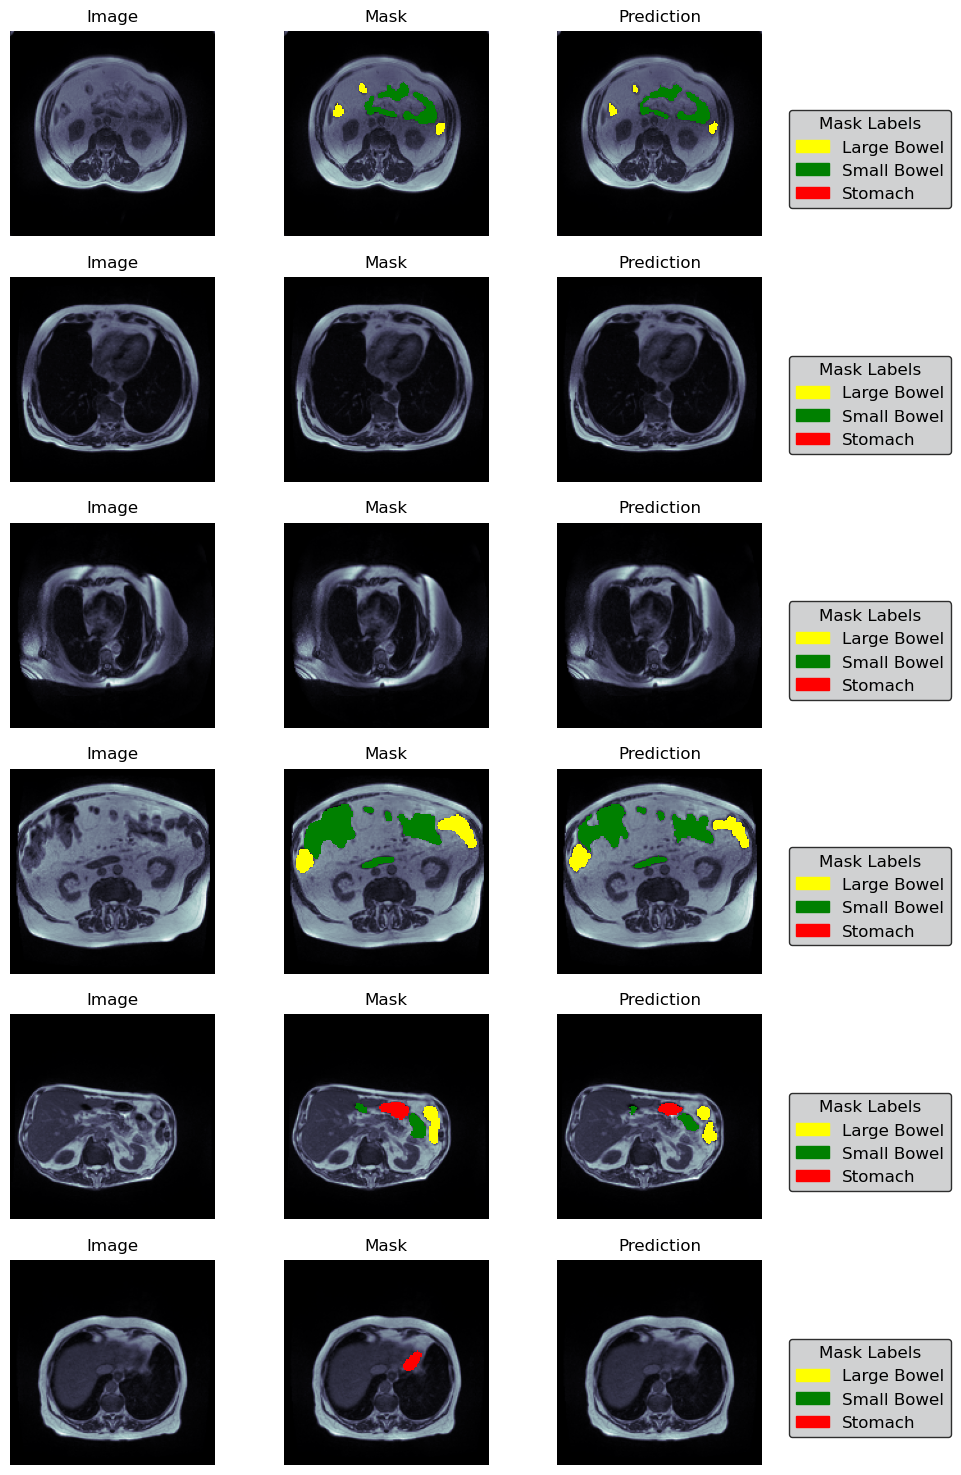

In [29]:
test_batches = CancerImages(160,160,test_set.iloc[400:406,:],subset="train", batch_size = 1, shuffle=False)
preds = model.predict(test_batches,verbose=1) 

Threshold = 0.5

## Caricamento
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=8, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

## Compariamo validazione e predizione
for i in range(6):
    
    ## Carichiamo immagini e maschere dal validation set
    images, mask = test_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ## Carichiamo le maschere relative la predizione
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    ## Se una certa soglia viene superata (0.5), vi è maschera di predizione  
    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Prediction", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')

Come è possibile notare, su 6 predizioni di immagini campione:
1. 4 predizioni risultano corrette;
2. La predizione n.5 è parzialmente corretta: non vengono identificate piccole porzioni di segmentazione relative a ciascuna classe;
3. La predizione n.6 risulta non corretta: il modello predice l'assenza di segmentazione, quando in realtà ne è presente una relativa alla classe 'stomach'